In [1]:
import ujson as json
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import sklearn.cluster as clstr
import scipy.sparse as sp
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
import seaborn as sb
import pandas as pd
import itertools

In [54]:
type_1_files = ['2_train.json', '2_test.json', '1_test.json', '1_train.json']
type_2_files = ['Apsaras3.json', '2_test_2.json']
positions = []
grottoes = []
files = []
ARTIC_NAMES = {'foot 1': 0,
               'foot 2': 1,
               'knee 1': 2,
               'knee 2': 3,
               'belly': 4,
               'elbow 1': 5,
               'elbow 2': 6,
               'hand 1': 7,
               'hand 2': 8,
               'eye 1': 9,
               'eye 2': 10,
               'shoulder 1': 11,
               'shoulder 2': 12}
for f in type_1_files: 
    file = open(f)
    data = json.load(file)
    for i in range(0,len(data)):
        apsara = data[i]
        files.append(apsara['apsaras']['file'])
        grottoes.append(apsara['apsaras']['grottoe'])
        access = apsara['apsaras']['positions']
        position = []
        for articulation in ARTIC_NAMES.keys():
            position.append(access[articulation])
        positions.append(position)

for f in type_2_files: 
    file = open(f)
    data = json.load(file) 
    for apsara in data['apsaras']:
        grottoes.append(apsara['grottoe'])
        files.append(apsara['file'])
        access = apsara['positions']
        position = []
        for articulation in ARTIC_NAMES.keys():
            position.append(access[articulation])
        positions.append(position)
        
positions = np.array(positions)

In [55]:
positions.shape

(557, 13, 2)

In [63]:
def plot_line(apsara, a1, a2, ax, c='black'):
    """
    Plot the leg/arm/... between articulations a1 and a2
    """
    i1 = ARTIC_NAMES[a1]
    i2 = ARTIC_NAMES[a2]
    ax.plot(apsara[(i1, i2), 0], apsara[(i1, i2), 1], c)
def plot_pose(apsara, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    plot_line(apsara, 'foot 1', 'knee 1', ax)
    plot_line(apsara, 'knee 1', 'belly', ax)
    plot_line(apsara, 'foot 2', 'knee 2', ax)
    plot_line(apsara, 'knee 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'belly', ax)
    plot_line(apsara, 'shoulder 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'elbow 1', ax)
    plot_line(apsara, 'shoulder 2', 'elbow 2', ax)
    plot_line(apsara, 'elbow 1', 'hand 1', ax)
    plot_line(apsara, 'elbow 2', 'hand 2', ax)
    plot_line(apsara, 'shoulder 1', 'shoulder 2', ax)
    plot_line(apsara, 'eye 1', 'eye 2', ax)

def plot_all(apsaras, line_length=12):
    fig, ax = plt.subplots()
    for i, apsara in enumerate(apsaras):
        plot_pose(apsara + 5*np.array([[i%line_length, i//line_length]]), ax=ax)

In [64]:
def preprocess(data):    
    data = 1.*np.delete(data, np.all(np.all(data==-1, axis=1), axis=1), axis=0)
    data[data==-1] = np.nan
    norm_data = (data - np.nanmean(data, axis=1)[:, None, :]) / np.nanstd(data, axis=1, ddof=1)[:, None, :]
    return -norm_data

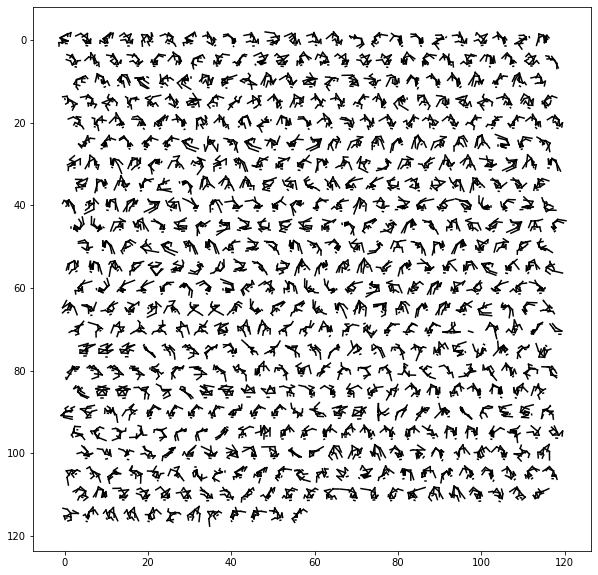

In [66]:
plot_all(preprocess(positions), np.sqrt(positions.shape[0]))
plt.savefig("output.png")

In [67]:
def remove_nans(data):
    return np.delete(data, 
                     np.any(np.any(np.isnan(data),
                                   axis=1),
                            axis=1),
                     axis=0)
def prepare_kmeans(data, n_clusters):
    data = remove_nans(preprocess(data))
    flat_data = data.reshape(data.shape[0], -1)
    kmeans = clstr.KMeans(n_clusters=n_clusters).fit(flat_data)
    return kmeans

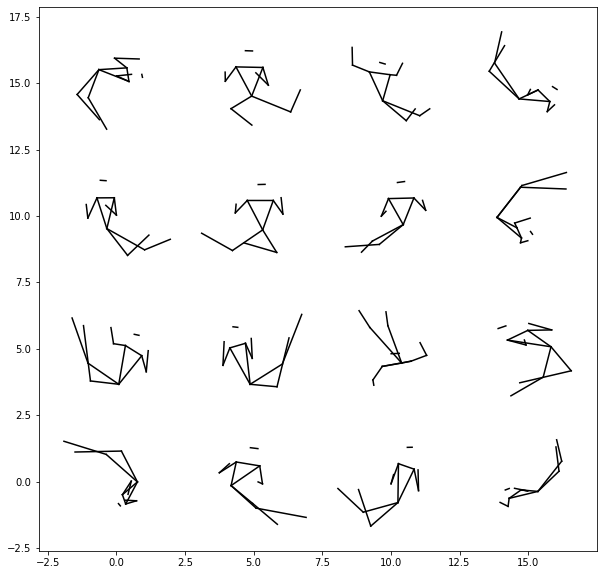

In [68]:
km = prepare_kmeans(positions, 16)
centers = km.cluster_centers_
plot_all(centers.reshape(centers.shape[0], -1, 2), line_length=4)

# Temporal analysis

In [79]:
df = pd.DataFrame(positions.reshape(positions.shape[0],-1), columns= pd.MultiIndex.from_product([ARTIC_NAMES.keys(),['x','y']]))

In [81]:
df['file'] = files

In [82]:
df

foot 1      foot 2      knee 1      knee 2      belly       ... hand 2  \
         x    y      x    y      x    y      x    y     x    y  ...      y   
0      621  463    586  464    624  528    577  557   728  427  ...    284   
1      529  590    346  554    385  672    198  671   201  509  ...    378   
2      265  657    206  656    235  766    189  755   369  640  ...    632   
3      499  532    378  498    372  639    167  608   219  435  ...    251   
4      401  528    335  604    417  621    421  743   269  736  ...    717   
..     ...  ...    ...  ...    ...  ...    ...  ...   ...  ...  ...    ...   
552    390  291    360  450    411  411    438  530   295  532  ...    510   
553    286  241     92  195    244  172    184  203   333  207  ...    124   
554    286  241     92  195    244  172    184  203   333  207  ...    124   
555    329  254    250  213    271  250    230  295   171  224  ...    152   
556    302  202    172  230    321  280    250  271   394  193  ...    204   

    eye 1      eye 2      shoulder 1      shoulder 2                     file  
        x    y     x    y          x    y          x    y                      
0     653  280   632  279        686  308        619  347       sui-419--.bmp  
1     232  262   196  253        237  340        113  342  beizhou-296-1a.bmp  
2     336  485   305  490        342  544        293  553      sui-419-1c.bmp  
3     249  162   214  162        283  286        177  288  beizhou-290-1n.bmp  
4     137  607   120  614        197  620        151  667      sui-420-1f.bmp  
..    ...  ...   ...  ...        ...  ...        ...  ...                 ...  
552   190  465   164  476        247  487        179  519          sui-313-1d  
553   366  105   361  101        337  136        378  146          sui-388-1a  
554   366  105   361  101        337  136        378  146          sui-388-1a  
555   123  108   109  110        174  135        114  154          sui-390-1b  
556   440   94   419   94        444  141        392  144          sui-390-1e  

[557 rows x 27 columns]

In [86]:
df.iloc[0]['foot 1']

x    621
y    463
Name: 0, dtype: object

In [91]:
df.replace(-1, None)

foot 1      foot 2      knee 1      knee 2      belly       ... hand 2  \
         x    y      x    y      x    y      x    y     x    y  ...      y   
0      621  463    586  464    624  528    577  557   728  427  ...    284   
1      529  590    346  554    385  672    198  671   201  509  ...    378   
2      265  657    206  656    235  766    189  755   369  640  ...    632   
3      499  532    378  498    372  639    167  608   219  435  ...    251   
4      401  528    335  604    417  621    421  743   269  736  ...    717   
..     ...  ...    ...  ...    ...  ...    ...  ...   ...  ...  ...    ...   
552    390  291    360  450    411  411    438  530   295  532  ...    510   
553    286  241     92  195    244  172    184  203   333  207  ...    124   
554    286  241     92  195    244  172    184  203   333  207  ...    124   
555    329  254    250  213    271  250    230  295   171  224  ...    152   
556    302  202    172  230    321  280    250  271   394  193  ...    204   

    eye 1      eye 2      shoulder 1      shoulder 2                     file  
        x    y     x    y          x    y          x    y                      
0     653  280   632  279        686  308        619  347       sui-419--.bmp  
1     232  262   196  253        237  340        113  342  beizhou-296-1a.bmp  
2     336  485   305  490        342  544        293  553      sui-419-1c.bmp  
3     249  162   214  162        283  286        177  288  beizhou-290-1n.bmp  
4     137  607   120  614        197  620        151  667      sui-420-1f.bmp  
..    ...  ...   ...  ...        ...  ...        ...  ...                 ...  
552   190  465   164  476        247  487        179  519          sui-313-1d  
553   366  105   361  101        337  136        378  146          sui-388-1a  
554   366  105   361  101        337  136        378  146          sui-388-1a  
555   123  108   109  110        174  135        114  154          sui-390-1b  
556   440   94   419   94        444  141        392  144          sui-390-1e  

[557 rows x 27 columns]

In [ ]:
def preprocess(data):    
    data = 1.*np.delete(data, np.all(np.all(data==-1, axis=1), axis=1), axis=0)
    data[data==-1] = np.nan
    norm_data = (data - np.nanmean(data, axis=1)[:, None, :]) / np.nanstd(data, axis=1, ddof=1)[:, None, :]
    return -norm_data

In [105]:
np.array(df.iloc[:, :-1, 'x']).shape

(557, 26)

In [133]:
df.iloc[:, :-1].groupby(axis=1,level=1).mean()
df.iloc[:,:-1].groupby(axis=1, level=1).std()

0       59.535058
1      117.533956
2       78.141473
3      123.461091
4      114.810379
          ...    
552    112.448621
553     82.052829
554     82.052829
555     83.979775
556     92.958014
Name: x, Length: 557, dtype: float64

In [132]:
df.xs('x',axis = 1, level=1)

foot 1  foot 2  knee 1  knee 2  belly  elbow 1  elbow 2  hand 1  hand 2  \
0       621     586     624     577    728      751      696     751     703   
1       529     346     385     198    201      317      107     193     179   
2       265     206     235     189    369      430      304     437     376   
3       499     378     372     167    219      331      122     468     133   
4       401     335     417     421    269      262      153     209     118   
..      ...     ...     ...     ...    ...      ...      ...     ...     ...   
552     390     360     411     438    295      288      150     230      74   
553     286      92     244     184    333      304      338     253     333   
554     286      92     244     184    333      304      338     253     333   
555     329     250     271     230    171      224       85     288      70   
556     302     172     321     250    394      498      388     446     458   

     eye 1  eye 2  shoulder 1  shoulder 2  
0      653    632         686         619  
1      232    196         237         113  
2      336    305         342         293  
3      249    214         283         177  
4      137    120         197         151  
..     ...    ...         ...         ...  
552    190    164         247         179  
553    366    361         337         378  
554    366    361         337         378  
555    123    109         174         114  
556    440    419         444         392  

[557 rows x 13 columns]

In [102]:
norm = (np.array(df.iloc[:, :-1]) - np.nanmean(df.iloc[:, :-1], axis=1).reshape([len(df), len(ARTIC_NAMES)]) / np.nanmean(df.iloc[:, :-1], axis=1))

ValueError: operands could not be broadcast together with shapes (557,26) (557,) 

In [ ]:
def preprocess(df): 
    df.replace(-1, None) #replace -1 with none
    norm

In [89]:
def plot_line(apsara, a1, a2, ax, c='black'):
    """
    Plot the leg/arm/... between articulations a1 and a2
    """
    i1 = ARTIC_NAMES[a1]
    i2 = ARTIC_NAMES[a2]
    print(apsara[a1]['x'])
    ax.plot(apsara[a1]['x'], apsara[a2]['y'], c)
def plot_pose(apsara, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.gca().invert_yaxis()
    plot_line(apsara, 'foot 1', 'knee 1', ax)
    plot_line(apsara, 'knee 1', 'belly', ax)
    plot_line(apsara, 'foot 2', 'knee 2', ax)
    plot_line(apsara, 'knee 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'belly', ax)
    plot_line(apsara, 'shoulder 2', 'belly', ax)
    plot_line(apsara, 'shoulder 1', 'elbow 1', ax)
    plot_line(apsara, 'shoulder 2', 'elbow 2', ax)
    plot_line(apsara, 'elbow 1', 'hand 1', ax)
    plot_line(apsara, 'elbow 2', 'hand 2', ax)
    plot_line(apsara, 'shoulder 1', 'shoulder 2', ax)
    plot_line(apsara, 'eye 1', 'eye 2', ax)

621
624
586
577
686
619
686
619
751
696
686
653


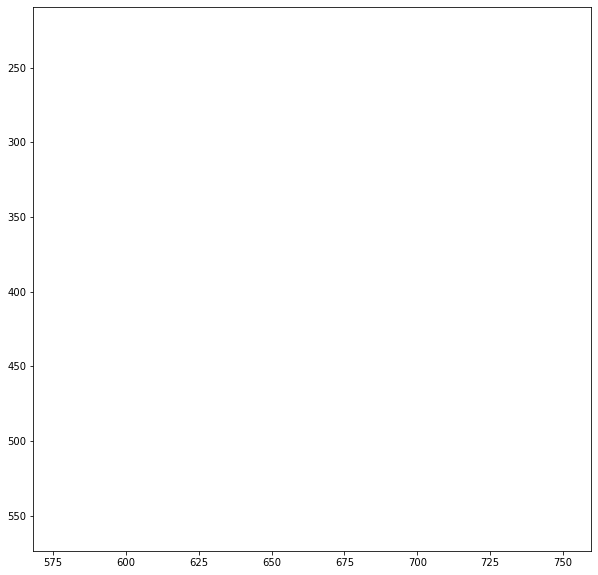

In [90]:
plot_pose(df.iloc[0])